In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
train_dir = 'sickmushrooms_sources2/sickmushrooms_sources/seg_train'
test_dir = 'sickmushrooms_sources2/sickmushrooms_sources/seg_test'
pred_dir = 'sickmushrooms_sources2/sickmushrooms_sources/seg_pred'

In [4]:
# assign class labels
class_names = ['oyster_blue','oyster_brown',
               'pleurotus_blue','pleurotus_brown','pleurotus_white',
               'portobello_blue', 'portobello_brown', 'portobello_white',
               'shiitake_blue','shiitake_brown','shiitake_white', 
               'winter_black', 'winter_blue', 'winter_white']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'oyster_blue': 0, 'oyster_brown': 1, 'pleurotus_blue': 2, 'pleurotus_brown': 3, 'pleurotus_white': 4, 'portobello_blue': 5, 'portobello_brown': 6, 'portobello_white': 7, 'shiitake_blue': 8, 'shiitake_brown': 9, 'shiitake_white': 10, 'winter_black': 11, 'winter_blue': 12, 'winter_white': 13}


In [5]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path)) 

# 팽이 흰털곰팡이병(winter_white)은 데이터가별로 없음

2066
2057
2112
2112
1827
2057
2075
2109
2102
1914
2142
1980
2067
474


In [6]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 


In [7]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading sickmushrooms_sources2/sickmushrooms_sources/seg_train


100%|████████████████████████████████████████████████████████████████████████████████| 474/474 [00:09<00:00, 50.15it/s]


Images file have been loaded
loading sickmushrooms_sources2/sickmushrooms_sources/seg_test


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 57.63it/s]


Images file have been loaded


In [8]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(27094, 27094)

In [9]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(6698, 6698)

In [10]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((27094, 150, 150, 3), (6698, 150, 150, 3))

In [11]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=42)

In [12]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=42)

In [13]:
# keeping 12000 data instances for training and testing our model
train_images = train_images[:12000]
train_labels = train_labels[:12000]

In [14]:
test_images = test_images[:2800]
test_labels = test_labels[:2800]

In [15]:
# normalize the images dataset
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [16]:
# let's see proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

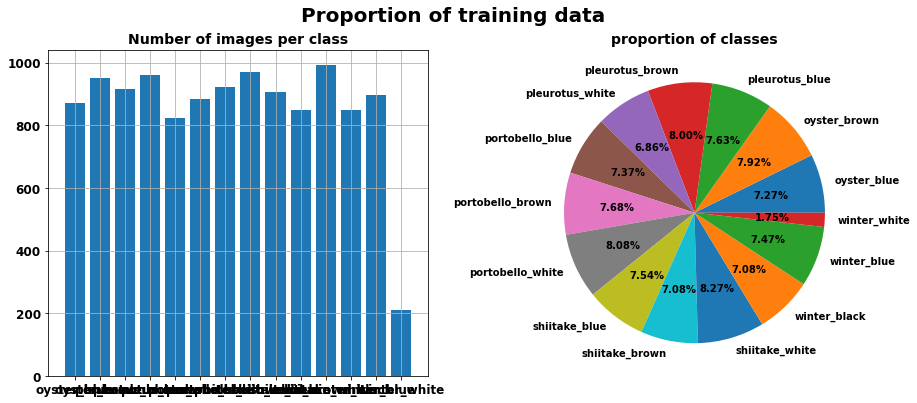

In [17]:
final_s = proportion_labels(train_labels, "training")

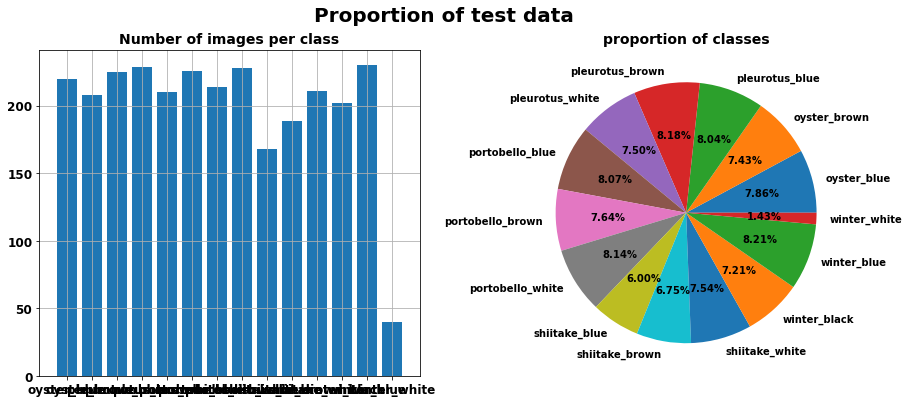

In [18]:
test_d = proportion_labels(test_labels, "test")

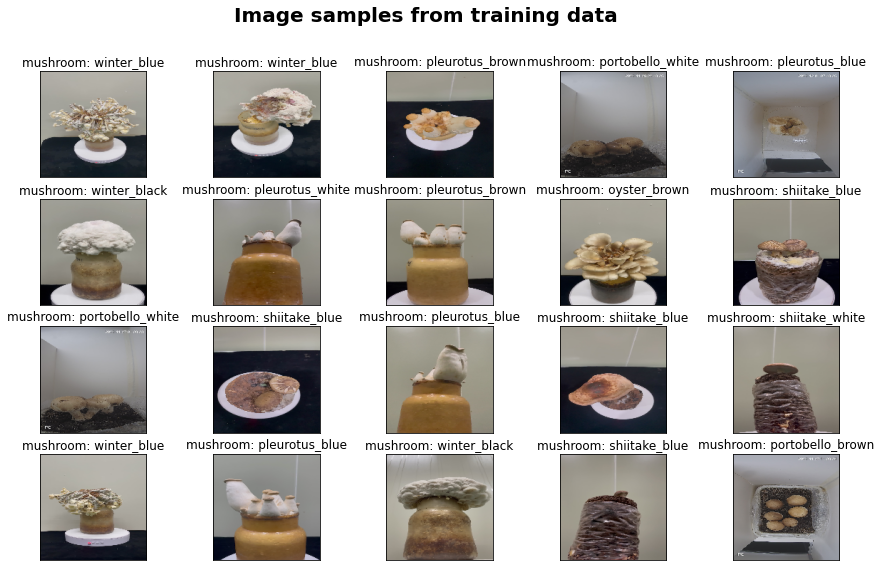

In [19]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'mushroom: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

In [20]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14, activation='softmax'))

In [21]:
# convert labels to categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [23]:
# fit model to the data
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
94/94 [==============================] - 90s 958ms/step - loss: 0.5724 - accuracy: 0.7777 - val_loss: 2.0268 - val_accuracy: 0.4725
Epoch 2/15
94/94 [==============================] - 90s 961ms/step - loss: 0.4744 - accuracy: 0.8197 - val_loss: 1.9109 - val_accuracy: 0.5025
Epoch 3/15
94/94 [==============================] - 98s 1s/step - loss: 0.4176 - accuracy: 0.8411 - val_loss: 2.2589 - val_accuracy: 0.4829
Epoch 4/15
94/94 [==============================] - 99s 1s/step - loss: 0.3777 - accuracy: 0.8577 - val_loss: 2.2990 - val_accuracy: 0.5039
Epoch 5/15
94/94 [==============================] - 92s 984ms/step - loss: 0.3417 - accuracy: 0.8712 - val_loss: 2.3007 - val_accuracy: 0.4861
Epoch 6/15
94/94 [==============================] - 97s 1s/step - loss: 0.3135 - accuracy: 0.8826 - val_loss: 2.4848 - val_accuracy: 0.4621
Epoch 7/15
94/94 [==============================] - 94s 999ms/step - loss: 0.2733 - accuracy: 0.8954 - val_loss: 2.0848 - val_accuracy: 0.4807
Epoch 00

In [59]:
# # saving model in H5 format
# model.save('sickmushroom_classifier.h5')

In [24]:
from tensorflow.keras.models import load_model
model = load_model('sickmushroom_classifier.h5')

In [25]:
# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 2.213674306869507 0.5378571152687073


In [ ]:
###################################################################################

Plot the Loss and accuracy curves

In [26]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

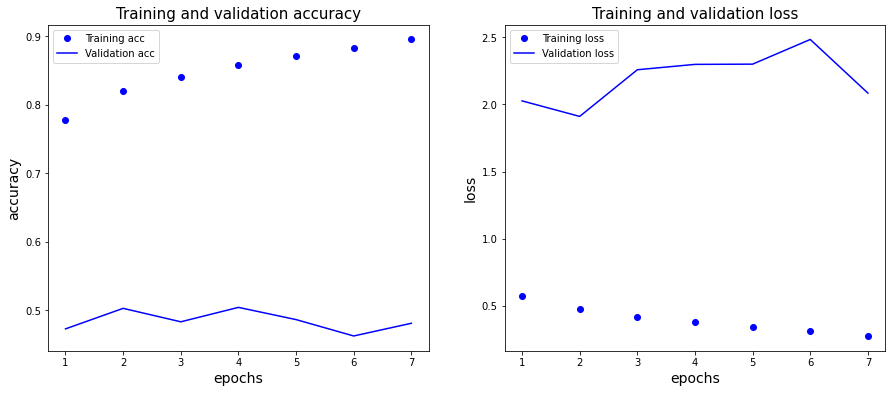

In [27]:
# call the function to plot the curves
plot_loss_accuracy(history)

In [30]:
#신경쓰지마 
# def display_random_image(class_names, images, labels):
    
#     index = np.random.randint(images.shape[0])
#     plt.figure()
#     plt.imshow(images[index])
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.title('Predicte Image #{} : '.format(index) + class_names[labels[index]])
#     plt.show()

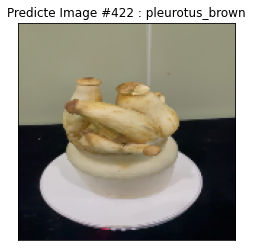

In [31]:
#신경쓰지마2
# predictions = model.predict(tst_images_norm)
# pred_labels = np.argmax(predictions, axis = 1) 

# display_random_image(class_names, tst_images_norm, pred_labels)

Making predictions

In [44]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=150, scale=True):
#   """
#   Reads in an image from filename, turns it into a tensor and reshapes into
#   specified shape (img_shape, img_shape, color_channels=3).

#   Args:
#     filename (str): path to target image
#     image_shape (int): height/width dimension of target image size
#     scale (bool): scale pixel values from 0-255 to 0-1 or not
  
#   Returns:
#     Image tensor of shape (img_shape, img_shape, 3)
#   """
  # Read in the image
    img = tf.io.read_file(filename)

  # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

  # Resize the image
  # img = tf.image.resize(img, [img_shape, img_shape])
    img = tf.image.resize(img, list(IMAGE_SIZE))

  # Scale? Yes/no
    if scale: # rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale images for EfficientNet models in TensorFlow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sickmushrooms_sources2/sickmushrooms_sources/seg_pred/shiitake1_11_18581863.jpg
sickmushrooms_sources2/sickmushrooms_sources/seg_pred/oyster1_13_16121767.jpg
sickmushrooms_sources2/sickmushrooms_sources/seg_pred/portobello1_3_17185926.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


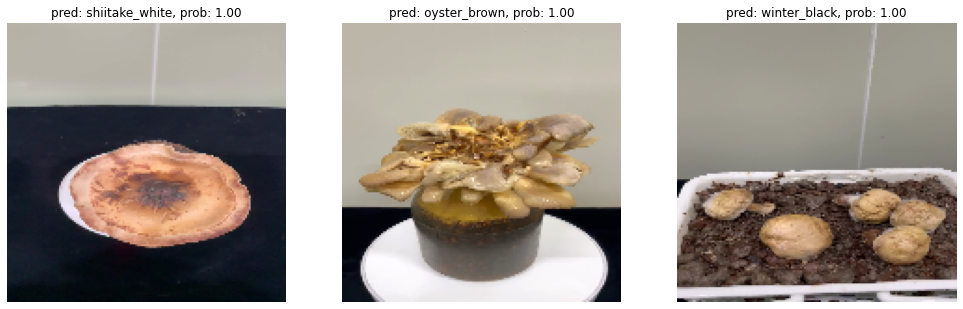

In [46]:
# Make preds on a series of random images
import os
import random

PRED_DIR: str ="sickmushrooms_sources2/sickmushrooms_sources/seg_pred"
plt.figure(figsize=(17, 10))
for i in range(3): # Choose random image(s) from random class(es)
    filename = random.choice(os.listdir(PRED_DIR))
    filepath = PRED_DIR + "/" + filename
    print(filepath)
  # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()]
    
    plt.subplot(1, 3, i+1)
    plt.imshow(img/225.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False);

In [50]:
#json파일로 정답 확인해본 결과 #표고_푸른곰팡이병 #느타리_세균갈색무늬병 #양송이_푸른곰팡이병

In [ ]:
#################################################################################################

In [ ]:
#VGG16#

In [28]:
# next up model using pretrained model vgg16 to improve accuracy to 85-90% and machine visualization
# initializing convolutional base of vgg16
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                 )

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [29]:
# Extract training feature map from vgg16 conv_base
train_featuremap = conv_base.predict(trn_images_norm)
test_featuremap = conv_base.predict(tst_images_norm) 

In [66]:
# print the shape of output tensors from convolutionla base -vgg16
train_featuremap.shape, test_featuremap.shape

((12000, 4, 4, 512), (2800, 4, 4, 512))

In [67]:
# train the model by adding dense layers on top of extracted features
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(4,4,512)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(14, activation='softmax'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 14)                3598      
                                                                 
Total params: 2,101,006
Trainable params: 2,101,006
Non-trainable params: 0
_________________________________________________________________


In [68]:
# compile the model with 'RMSprop' optimizer
model2.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [71]:
# fit the model to datr and save the model statistics to result instance
result = model2.fit(train_featuremap, train_labels,
                   batch_size=256,
                   epochs=30,
                   validation_data=(test_featuremap, test_labels),
                   callbacks=callback_list
                   )

# print the final test accuracy and loss
tst_loss, tst_acc = model2.evaluate(test_featuremap, test_labels, verbose=0)
print("Test loss and accuracy of model2:", tst_loss, tst_acc)

Epoch 1/30
47/47 [==============================] - 1s 23ms/step - loss: 0.2778 - accuracy: 0.9158 - val_loss: 1.2485 - val_accuracy: 0.5339
Epoch 2/30
47/47 [==============================] - 1s 22ms/step - loss: 0.2657 - accuracy: 0.9227 - val_loss: 1.2343 - val_accuracy: 0.5275
Epoch 3/30
47/47 [==============================] - 1s 22ms/step - loss: 0.2605 - accuracy: 0.9221 - val_loss: 1.2554 - val_accuracy: 0.5382
Epoch 4/30
47/47 [==============================] - 1s 22ms/step - loss: 0.2575 - accuracy: 0.9231 - val_loss: 1.2560 - val_accuracy: 0.5357
Epoch 5/30
47/47 [==============================] - 1s 22ms/step - loss: 0.2542 - accuracy: 0.9219 - val_loss: 1.2301 - val_accuracy: 0.5361
Epoch 6/30
47/47 [==============================] - 1s 22ms/step - loss: 0.2469 - accuracy: 0.9289 - val_loss: 1.2531 - val_accuracy: 0.5414
Epoch 7/30
47/47 [==============================] - 1s 23ms/step - loss: 0.2410 - accuracy: 0.9311 - val_loss: 1.2559 - val_accuracy: 0.5396
Epoch 8/30
47

In [72]:
# saving model2 with h5 extension
# model2.save("mushroom_classifier2.h5")

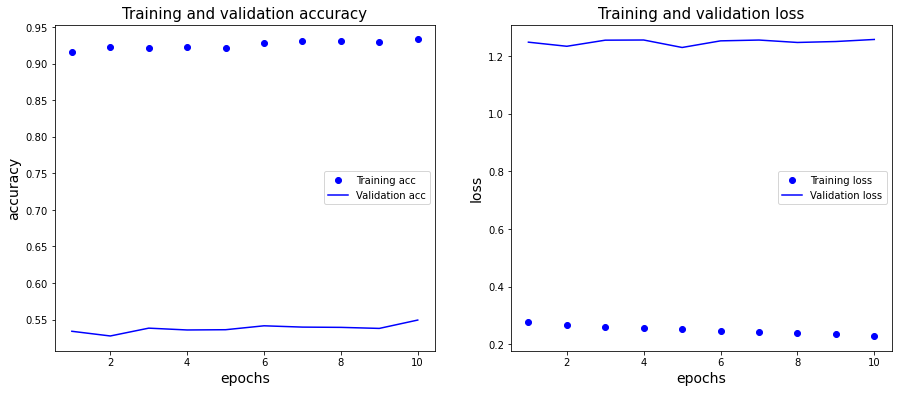

In [73]:
# plotting loss and accuracy curves
plot_loss_accuracy(result)